# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.hankel import HankelTransform, mirrorGrid
from rkstiff.etd35 import ETD35
from rkstiff.grids import construct_x_kx_fft
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Helper functions 

In [2]:
def waterfall(x,t,u,**kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(figsize=kwargs['figsize'])
    else:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    for i,snapshot in enumerate(u):
        ax.plot(x,t[i]*np.ones_like(x),snapshot,color='black')
    plt.xlim([x[0],x[-1]])
    plt.ylim([t[0],t[-1]])
    plt.tight_layout()
    return ax

# Radial grid setup with Hankel Transform

In [3]:
nr = 100
rmax = 5
HT = HankelTransform(nr=nr,rmax=rmax)

# NLS linear and nonlinear operators

In [4]:
L = -1j*HT.kr**2 
gamma = 2
def NL(g):
    f = HT.iht(g)
    f2 = f.real**2 + f.imag**2
    return 1j*gamma*HT.ht(f2*f)

# Initial value profile

Text(0, 0.5, 'log|u0HT|^2')

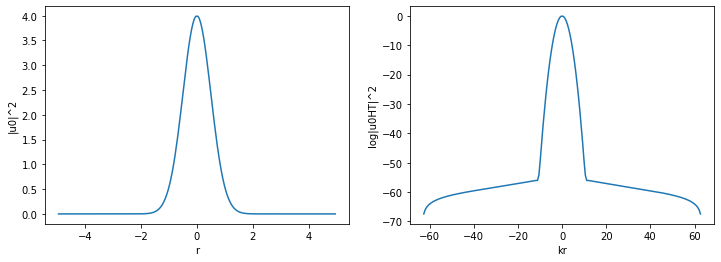

In [5]:
# If A0 is large enough then the initial profile with collapse into singularity (otherwise it will spread out)
a = 1
A0 = 2
u0 = A0*np.exp(-a*HT.r**2)
u0HT = HT.ht(u0)
r,u0full = mirrorGrid(HT.r,u0)
kr,u0HTfull = mirrorGrid(HT.kr,u0HT)
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(r,np.abs(u0full)**2)
ax[0].set_xlabel('r')
ax[0].set_ylabel('|u0|^2')
ax[1].plot(kr,np.log(np.abs(u0HTfull)**2))
ax[1].set_xlabel('kr')
ax[1].set_ylabel('log|u0HT|^2')

# Setup ETD35 solver and propagate

Text(0.5, 0.92, 'Magnitude')

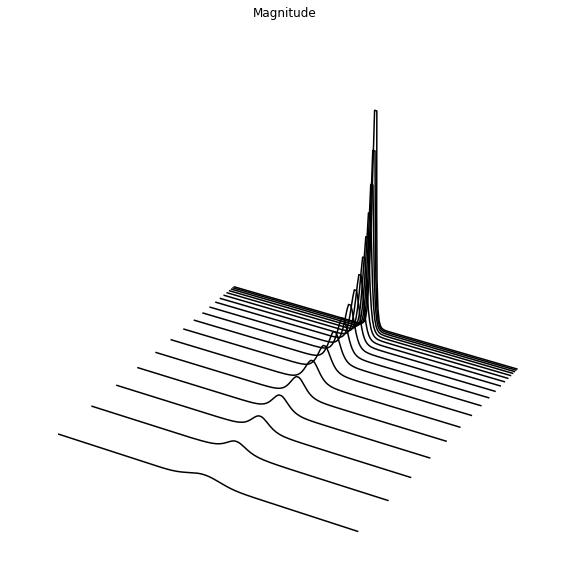

In [6]:
solver = ETD35(linop=L,NLfunc=NL,epsilon=1e-5)
uHT = solver.evolve(u0HT,t0=0,tf=0.8,store_data=True,store_freq=10)

U = []
for u in solver.u:
    uRS = HT.iht(u)
    umag = uRS.real**2 + uRS.imag**2
    r,u = mirrorGrid(HT.r,umag) # extends r grid from [0,rmax] to [-rmax,rmax] by mirroring arrays
    U.append(u)
U = np.array(U)
t = np.array(solver.t)
ax = waterfall(r,t,U,figsize=(8,8))
ax.grid(False)
ax.axis(False)
ax.set_title('Magnitude')

# Radial and temporal grid setup for multi-variable NLS

In [235]:
nr = 80
rmax = 4
HT.rmax = rmax
HT.nr = nr

nt = 512
a, b = -6, 6
t,omega = construct_x_kx_fft(nt,a,b)

# 2D matrices for real-space and spectral space components
R,T = np.meshgrid(HT.r,t,indexing='ij')
KR,OMEGA = np.meshgrid(HT.kr,omega,indexing='ij')

# Initial value profile

Text(0.5, 1.0, 'initial spectrum')

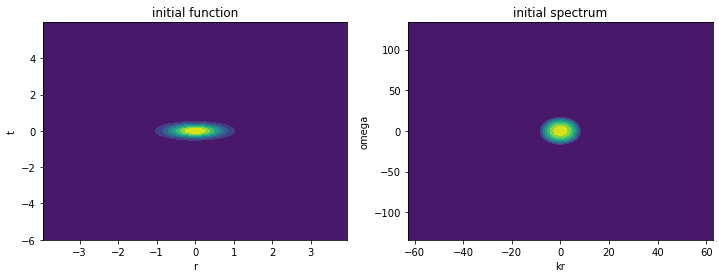

In [236]:
R0 = 1
phaseR = 0
T0 = 0.5
phaseT = 0
A0 = 4
U0 = A0*np.exp(-(R/R0)**2- (T/T0)**2)*np.exp(1j*(phaseR*R + phaseT*T))
# Hankel transform taken over axis 0, FFT taken over axis 1
U0FFT_HT = np.fft.fft(HT.ht(U0),axis=1)

fig, ax = plt.subplots(1,2,figsize=(12,4))
rm, UM = mirrorGrid(HT.r,U0,axis=0)
RM,TM = np.meshgrid(rm,t,indexing='ij')
ax[0].contourf(RM,TM,UM.real**2 + UM.imag**2)
ax[0].set_xlabel('r')
ax[0].set_ylabel('t')
ax[0].set_title('initial function')

# complex fft omega grid is arranged with positive frequencies first in the array followed by negative frequencies 
# put these in increasing order to plot results
omega_ordered = np.hstack([omega[nt//2:], omega[:nt//2]])
U0OT = np.hstack([U0FFT_HT[:,nt//2:],U0FFT_HT[:,:nt//2]])
krm, U0OT = mirrorGrid(HT.kr,U0OT,axis=0)

KRM,OMEGAM = np.meshgrid(krm,omega_ordered,indexing='ij')
mag = U0OT.real**2 + U0OT.imag**2
# plotting the log, so to avoid taking a log of 0 we need this
mag[mag < 1e-12] = 1e-12
ax[1].contourf(KRM,OMEGAM,np.log(mag))
ax[1].set_xlabel('kr')
ax[1].set_ylabel('omega')
ax[1].set_title('initial spectrum')


# NLS with spatial (r) and temporal terms (t) 

In [237]:
sigma = 0.5
gamma = 2

L = -1j*KR**2 + 1j*sigma*OMEGA**2
# Flatten L since modes are independent and we have a diagonal system
L = L.flatten()

def NL(g):
    # Expand the 1D array to a 2D array with radius varying across rows and time across columns
    G = g.reshape(nr,nt)
    # Now we can take the inverse Hankel transform and inverse FFT to recover a real-space form
    # appropriate for computing the nonlinear response
    F = np.fft.ifft(HT.iht(G),axis=1)
    F2 = F.real**2 + F.imag**2
    # Compute NL response, then flatten back to a 1D array for use with RKstiff PDE solver
    return 1j*gamma*np.fft.fft(HT.ht(F2*F),axis=1).flatten()

# Initialize solver and propagate from z=0 to z=zf

In [238]:
z0, zf = 0, 0.3
store_freq = 4
solver = ETD35(linop=L,NLfunc=NL,epsilon=1e-5)
# flatten initial spectral array for solver
uHT = solver.evolve(U0FFT_HT.flatten(),t0=z0,tf=zf,store_data=True,store_freq=store_freq)

# Extract magnitudes for plotting

In [311]:
# Helper function
def extractRTForPlotting(t,omega,HT,solverU,rlimit,tlimits,freq=1):
    SU = np.array(solverU[0:-1:freq])
    SU = SU.reshape(len(SU),len(HT.kr),len(omega))
    RU = np.zeros(shape = (len(SU),len(HT.r),len(t)),dtype=np.complex128)
    for i in range(len(SU)):
        RU[i] = np.fft.ifft(HT.iht(SU[i]),axis=1)
    rnew = HT.r[HT.r < rlimit]
    tnew = t[(t > tlimits[0]) & (t < tlimits[1])]
    RU = RU[:,HT.r < rlimit,:]
    RU = RU[:,:,(t > tlimits[0]) & (t < tlimits[1])]
    rm_new = np.hstack([-np.flipud(rnew),rnew])
    UM = np.zeros(shape=(RU.shape[0],2*RU.shape[1],RU.shape[2]),dtype=np.complex128)
    for i in range(len(RU)):
        UM[i] = np.vstack([np.flipud(RU[i]),RU[i]])
    RM, TM = np.meshgrid(rm_new,tnew,indexing='ij')
    return RM,TM,UM

In [298]:
freq = 1
rlimit = 2
tlimits = [-3,3]
RM,TM,UM = extractRTForPlotting(t,omega,HT,solver.u,rlimit=rlimit,tlimits=tlimits,freq=freq)
MAG = UM.real**2 + UM.imag**2
MAG = MAG/MAG[0].max()
z = np.array(solver.t)

# Surface animation of propagation pulse splitting

<IPython.core.display.Javascript object>


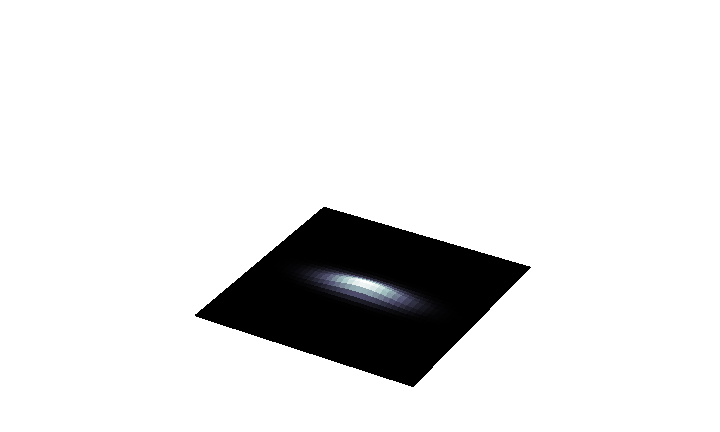

In [301]:
%matplotlib notebook

zmin, zmax = 0,20
interval = 200

fig = plt.figure(figsize=(10,6))
#ax = Axes3D(fig)
ax = fig.add_subplot(111,projection='3d')
ax.set_axis_off()
#ax.grid(False)
ax.set_facecolor('white')

ax.set_xlim(-rlimit,rlimit)
ax.set_ylim(tlimits[0],tlimits[1])
ax.set_zlim(zmin,zmax)

surface_opts = dict(
    cmap=cm.bone,edgecolors=None,antialiased=False,alpha=1
)
 
ax.plot_surface(RM,TM,MAG[0],**surface_opts)
ax.set_xlabel('r')
ax.set_ylabel('t')
fig.tight_layout()

def updateSurface(i):
    ax.collections = []
    ax.plot_surface(RM,TM,MAG[i],**surface_opts)
    ax.set_xlabel('r')
    ax.set_ylabel('t')
    #ax.set_title('z = {:.2f}'.format(z[i]))
    
anim = animation.FuncAnimation(fig, updateSurface,
                        frames=len(MAG),interval=interval,repeat=True,blit=False)
fig.show()

# 2D Cartesian setup for multi-variable NLS

<IPython.core.display.Javascript object>


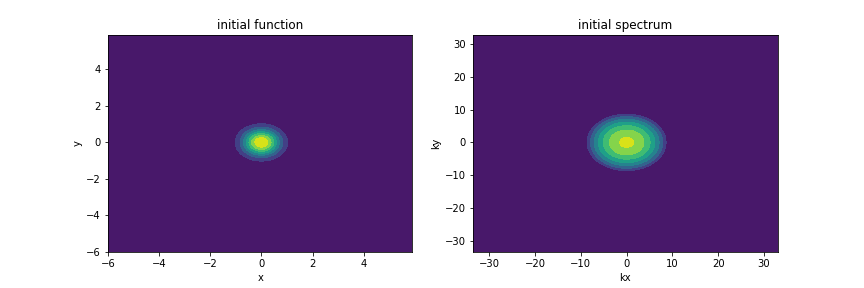

Text(0.5, 1.0, 'initial spectrum')

In [330]:
nx, ny = 128,128
ax,bx = -6,6
ay,by = -6,6
x,kx = construct_x_kx_fft(nx,ax,bx)
y,ky = construct_x_kx_fft(ny,ay,by)

# 2D matrices for real-space and spectral space components
X,Y = np.meshgrid(x,y,indexing='ij')
KX,KY= np.meshgrid(kx,ky,indexing='ij')

X0, Y0 = 1, 1
phaseX, phaseY = 0, 0
A0 = 2
U0 = A0*np.exp(-(X/X0)**2- (Y/Y0)**2)*np.exp(1j*(phaseX*X + phaseY*Y))
# Hankel transform taken over axis 0, FFT taken over axis 1
U0FFT = np.fft.fft2(U0)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].contourf(X,Y,U0.real**2 + U0.imag**2)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('initial function')

# complex fft kx/ky grids are arranged with positive frequencies first in the array followed by negative frequencies 
# put these in increasing order to plot results
kx_ordered = np.hstack([kx[nx//2:], kx[:nx//2]])
ky_ordered = np.hstack([ky[ny//2:], ky[:ny//2]])
nx_neg = np.hstack([U0FFT[nx//2:,ny//2:],U0FFT[nx//2:,:ny//2]])
nx_pos = np.hstack([U0FFT[:nx//2,ny//2:],U0FFT[:nx//2,:ny//2]])
U0OT = np.vstack([nx_neg,nx_pos])
KXO,KYO = np.meshgrid(kx_ordered,ky_ordered,indexing='ij')

mag = U0OT.real**2 + U0OT.imag**2
# plotting the log, so to avoid taking a log of 0 we need this
mag[mag < 1e-12] = 1e-12
ax[1].contourf(KXO,KYO,np.log(mag))
ax[1].set_xlabel('kx')
ax[1].set_ylabel('ky')
ax[1].set_title('initial spectrum')


# Operators and propagation of 2D-NLS

In [ ]:
gamma = 2
L = -1j*(KX**2 + KY**2)
# Flatten L since modes are independent and we have a diagonal system
L = L.flatten()

def NL(g):
    # Expand the 1D array to a 2D array with radius varying across rows and time across columns
    G = g.reshape(nx,ny)
    # Now we can take the inverse Hankel transform and inverse FFT to recover a real-space form
    # appropriate for computing the nonlinear response
    F = np.fft.ifft2(G)
    F2 = F.real**2 + F.imag**2
    # Compute NL response, then flatten back to a 1D array for use with RKstiff PDE solver
    return 1j*gamma*np.fft.fft2(F2*F).flatten()

solver = ETD35(linop=L,NLfunc=NL,epsilon=1e-4)
uHT = solver.evolve(U0FFT.flatten(),t0=0,tf=0.8,store_data=True,store_freq=4)

# Process data for animation

In [333]:
# Helper function
def extractXYForPlotting(x,y,kx,ky,solverU,xlimits,ylimits,freq=1):
    SU = np.array(solverU[0:-1:freq])
    SU = SU.reshape(len(SU),len(kx),len(ky))
    UE = np.zeros(shape = (len(SU),len(x),len(y)),dtype=np.complex128)
    for i in range(len(SU)):
        UE[i] = np.fft.ifft2(SU[i])
    x_idx = (x > xlimits[0]) & (x < xlimits[1])
    y_idx = (y > ylimits[0]) & (y < ylimits[1])
    xnew = x[x_idx]
    ynew = y[y_idx]
    UE = UE[:,x_idx,:]
    UE = UE[:,:,y_idx]
    XE,YE = np.meshgrid(xnew,ynew,indexing='ij')
    return XE,YE,UE

freq = 1
xlimits = [-2,2]
ylimits = [-2,2]
XE,YE,UE = extractXYForPlotting(x,y,kx,ky,solver.u,xlimits=xlimits,ylimits=ylimits,freq=freq)
MAG = UE.real**2 + UE.imag**2
MAG = MAG/MAG[0].max()
t = np.array(solver.t)

# Blow-up for 2D-NLS in Cartesian coordinates

<IPython.core.display.Javascript object>


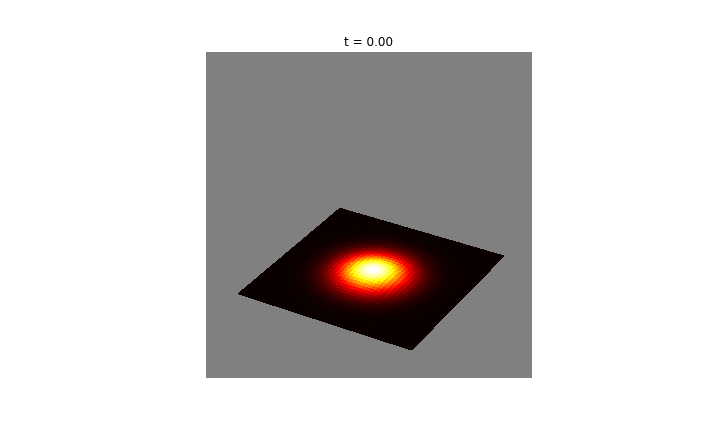

In [335]:
%matplotlib notebook
zmin, zmax = 0,30
interval = 200

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
ax.set_axis_off()
ax.set_facecolor('gray')

ax.set_xlim(xlimits[0],xlimits[1])
ax.set_ylim(ylimits[0],ylimits[1])
ax.set_zlim(zmin,zmax)

surface_opts = dict(
    cmap=cm.hot,edgecolors=None,antialiased=False,alpha=1
)
 
ax.plot_surface(XE,YE,MAG[0],**surface_opts)
ax.set_xlabel('x')
ax.set_ylabel('y')

def updateSurface(i):
    ax.collections = []
    ax.plot_surface(XE,YE,MAG[i],**surface_opts)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('t = {:.2f}'.format(t[i]))
    
anim = animation.FuncAnimation(fig, updateSurface,
                        frames=len(MAG),interval=interval,repeat=True,blit=False)
fig.show()